In [1]:
!pip install opendatasets -q

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [3]:
# Download dataset
od.download("https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachin419
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images


100%|██████████| 119M/119M [00:00<00:00, 757MB/s] 

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [5]:
train_data_dir = "/content/chest-ctscan-images/Data/test"
test_data_dir = "/content/chest-ctscan-images/Data/train"
validation_data_dir = "/content/chest-ctscan-images/Data/valid"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 315 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 613 files belonging to 4 classes.


In [6]:
class_names = train_data.class_names
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [7]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


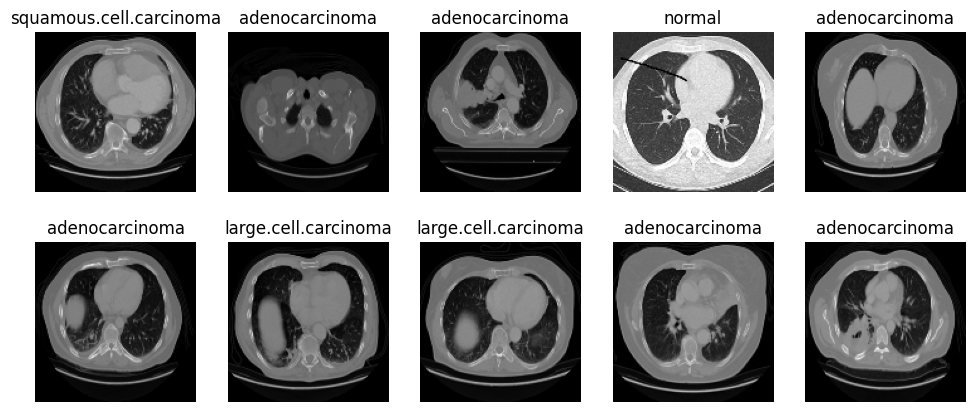

In [8]:
# plot data sample
plt.figure(figsize=(12,5))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [9]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)


tf.Tensor(
[[[[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   ...
   [ 0.          0.          0.        ]
   [ 0.10784912  0.10784912  0.10784912]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.1796875   0.1796875   0.1796875 ]
   [ 0.          0.          0.        ]
   ...
   [ 0.265625    0.265625    0.265625  ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   ...
   [ 0.33563232  0.33563232  0.33563232]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  ...

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   ...
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 

In [10]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

#**Transfer Learning**

In [11]:
from tensorflow.keras import Model, Input, layers

In [12]:
pretrained_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='max'
)

for layer in pretrained_model.layers:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# data_augmentation = tf.keras.Sequential(
#   [
#     tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#   ]
# )

In [14]:
inputs = Input(shape=(128, 128, 3))
x = pretrained_model(inputs)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)


In [15]:
model = Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,124,516 (61.51 MB)

 Trainable params: 9,087,012 (34.66 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=14,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.3427 - loss: 4.2611 - val_accuracy: 0.5238 - val_loss: 1.4045
Epoch 2/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - accuracy: 0.4272 - loss: 1.2821 - val_accuracy: 0.5429 - val_loss: 0.9591
Epoch 3/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.5383 - loss: 0.9322 - val_accuracy: 0.5460 - val_loss: 0.8879
Epoch 4/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.5992 - loss: 0.8850 - val_accuracy: 0.6032 - val_loss: 0.8683
Epoch 5/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.6418 - loss: 0.7719 - val_accuracy: 0.7238 - val_loss: 0.6284
Epoch 6/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7646 - loss: 0.5930 - val_accuracy: 0.7111 - val_loss: 0.6428
Epoch 7/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.7549 - loss: 0.5999 - val_accuracy: 0.8762 - val_loss: 0.4203
Epoch 8/14
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8814 - loss: 0.4145 - val_accuracy: 0.8

In [19]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 128.242 seconds


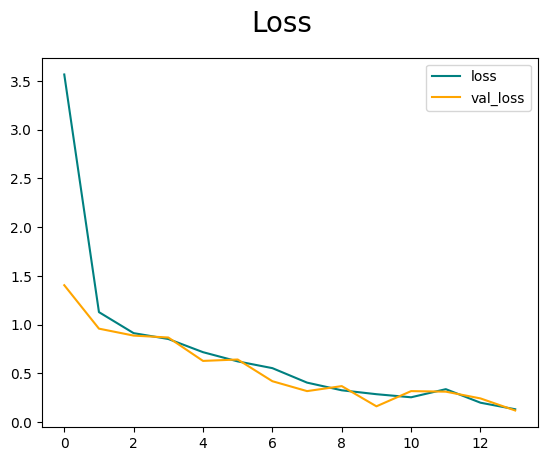

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

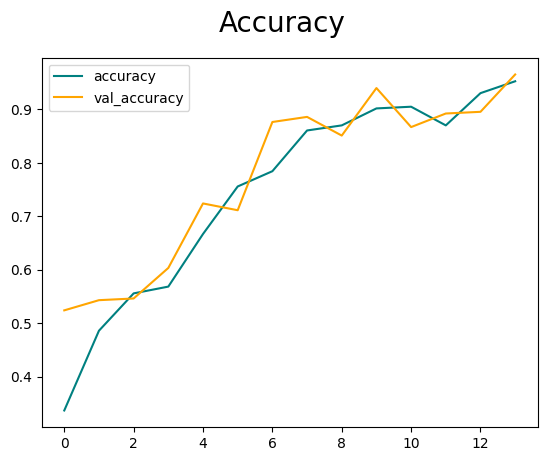

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

In [22]:
!pip install opencv-python -q

In [23]:
import cv2

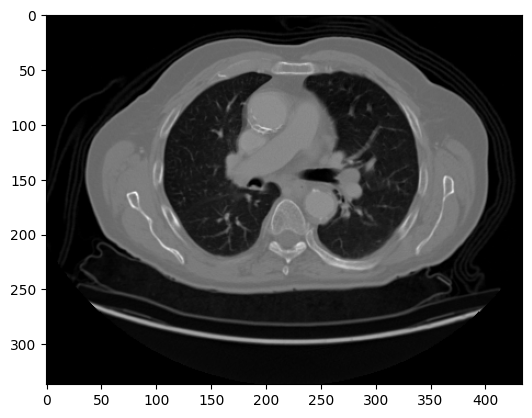

In [24]:
img = cv2.imread('/content/chest-ctscan-images/Data/test/squamous.cell.carcinoma/000112.png')
plt.imshow(img)
plt.show()

In [25]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [26]:
scaled_image.shape

TensorShape([128, 128, 3])

In [27]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [28]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


In [29]:
yhat

array([[0.00420417, 0.02480977, 0.00342785, 0.96755815]], dtype=float32)

In [30]:
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [31]:
predicted_class_index = np.argmax(yhat)
predicted_class_name = class_names[predicted_class_index]
print(f"The predicted class is: {predicted_class_name}")

The predicted class is: squamous.cell.carcinoma


##Save Model

In [32]:
#Save Model as Keras
model.save("Chest_cancer_detection_model.keras")

In [33]:
#Save Model as h5
model.save("Chest_cancer_detection_model.h5")

##Load Model

In [34]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

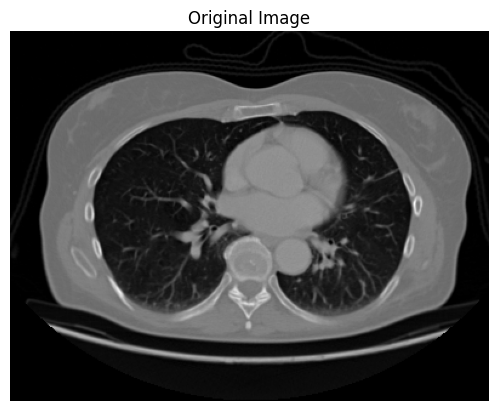

In [35]:
# Load the image
new_img_path = '/content/chest-ctscan-images/Data/test/large.cell.carcinoma/000111.png'
new_img = cv2.imread(new_img_path)
plt.imshow(new_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [36]:
#Using Keras
cancer_prediction_model = load_model('Chest_cancer_detection_model.keras')

In [37]:
# Preprocess the image
resized_new_img = tf.image.resize(new_img, IMAGE_SIZE)
scaled_new_img = resized_new_img/255.0
input_image = np.expand_dims(scaled_new_img, 0)

# Make a prediction
predictions = cancer_prediction_model.predict(input_image)

# Get the predicted class
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

print(f"The predicted class for the new image is: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
The predicted class for the new image is: large.cell.carcinoma


adenocarcinoma: 0.03%
large.cell.carcinoma: 99.95%
normal: 0.02%
squamous.cell.carcinoma: 0.01%


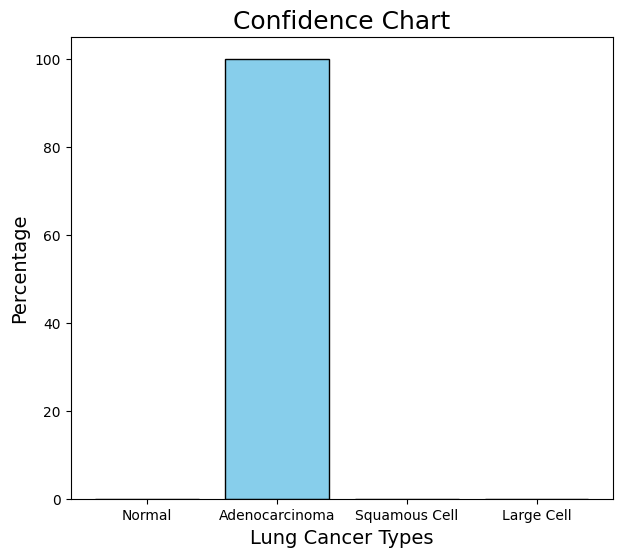

In [38]:
classes = ["Normal", "Adenocarcinoma", "Squamous Cell", "Large Cell"]
prediction_percentages = predictions[0] * 100

for i, percentage in enumerate(prediction_percentages):
    print(f"{class_names[i]}: {percentage:.2f}%")

#Confidence Chart
plt.figure(figsize=(7,6))
plt.bar(classes, prediction_percentages, color="skyblue", edgecolor="black")
plt.xlabel('Lung Cancer Types', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Confidence Chart', fontsize=18)


plt.savefig("confidence_chart.png", dpi=300, bbox_inches='tight')
plt.show()